<a href="https://colab.research.google.com/github/sp8rks/MaterialsInformatics/blob/main/worked_examples/GANs/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>  

# GANs

## What is a GAN?

Generative Adversarial Networks (GANs) are a class of machine learning models that have become popular in their ability to generate realistic data from noise. In this notebook we will look at training a GAN model on images of dendrite growth within a microstructure. This model will then be able to take random noise and turn it into similar images of dendrite growth. A GAN consists of two different neural networks, a generator and a discriminator, operating simultaneously in competition against one another.

#### The Generator

The generator is tasked with creating fake data that mimics the real data. It starts by taking random noise as an input and applying a series of transformations (such as convolutions and deconvolutions) to produce data that is as close as possible to the real data. The output can be really anything (text, images, etc) but in this notebook we will focus on images. The goal of the generator is to fool the discriminator into thinking the generated data is real. The generator starts out producing low quality images but trains itself to generate more realistic images as the number of training cycles increase. 

#### The Discriminator

The discriminator acts as a classification model that is tasked with discerning the real data from the fake data generated by the generator model. It trains itself to maximize its ability to tell the fake data apart from the real data. As the generator improves, and the fake data looks increasly similar to the real data, the discriminator faces a more difficult challenge. 

#### Adversarial Training

GANs are trained using a "min-max" game. The generator and discriminator are "adversaries", trying to outperform each other. The discriminator is trying to beat the generator by correctly classifying the data whereas the generator is trying to beat the discriminator by fooling it. As the training cycles increase, the discriminator becomes much better at being able to classify data and the generator becomes much better at generating realistic data. 

Video: https://www.youtube.com/watch?v=OW_2zFqQ1TA

### Imports 

For this notebook we will be using torch and foundry as our two main libraries. Torch helps supply the libraries needed for the GAN model whereas Foundry supplies the dataset we will be using.



In [ ]:
#install libraries
!pip install scikit-learn
!pip install foundry_ml
!pip install scikit-image
!pip install tensorflow
!pip install keras-unet
!pip install opencv-python

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from foundry import Foundry
import torch.nn.utils.spectral_norm as spectral_norm

### Load the Images

The following cell will interface with Foundry to recieve the dendrite images we will be using in this notebook. Then, we can display all the images in X to view what we are training the model on. The GAN model will generate images similar to the ones we train it on and so at the end of the notebook you will be able to compare the similarities between the real and generated fake images. 

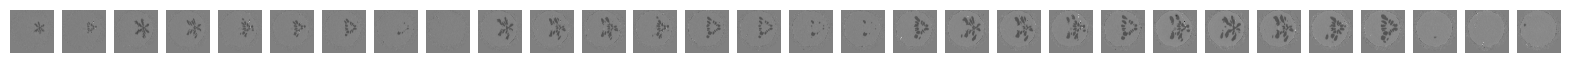

In [15]:
# If the data is not available in the "data" folder then uncomment and run this code
# Load the foundry dataset
f = Foundry(use_globus=False)
datasets = f.search("foundry_stan_segmentation_v1.1")
dataset = datasets.get_dataset_by_name("foundry_stan_segmentation_v1.1")

res = dataset.get_as_dict()
X = res['train']['input']['train/input']
y = res['train']['target']['train/output']

# display all images in X
fig, axs = plt.subplots(1, 30, figsize=(20, 30))
for i in range(30):
    axs[i].imshow(X[i])
    axs[i].axis('off')

## The Generator

### Setup 

To start we will make a generator. It's handy to be able to package the generator structure into a class for easy use later. We will use the neural network base from PyTorch (nn.Module). The generator is a neural network that looks to take in random noise and output a piece of realistic but fake data. 

- noise_dim defines the dimensionality of the noise which will be used as an input to the generator
- image_channels represents the number of channels the image will use. A full colored image (RGB) would be 3 channels
- feature_g controls the number of features in the layers of the generator. A higher number of features allows the model to capture more complexity in the data

We will set the neural network up as a Sequential NN (nn.Sequential) which allows us to create stacked layers to pass the noise through.

### The Layers

There are three main layers that make up the body of the model. These are used to "upsample" the input from a group of random noise to a piece of coherent data. Each "block" of layers (transpose -> batch -> ReLU) gradually increases the spatial resolution of the data.  We will consider the first "block" of layers:

#### ConvTranspose2d

This is a transpose convolution. It is used in generators to upscale an input.

- Noise vector is treated as a 1x1 "image" (noise_dim)
- The layer converts the noise into a feature map with size 4x4 (feature_g * 8)
- The arguments (4, 1, 0) define the kernel size (4x4), the stride (1), and the padding (0). These arguments control how the image is upsampled

#### BatchNorm2d

Normalizes the outputs of the previous layer (ConvTranspose2d). This helps stabilize the training process by ensuring the values remain within a reasonable range.

#### ReLU

This is a Rectified Linear Unit (ReLU) activation function. This introduces non-linearity which helps encourage the model learning complex patterns.

#### Output

After passing the noise through 4 of these "blocks" to upsample it to 32x32, the data is passeed through the final ConvTranspose2d layer. This layer takes the feature space and turns it into an image. Additionally, it doubles the resolution one final time to be 64x64. Lastly, the image is passed through the Tanh function which ensures the pixel values remain between -1 and 1. 

In [16]:

# Generator definition
class Generator(nn.Module):
    def __init__(self, noise_dim, image_channels, feature_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, feature_g * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_g * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 8, feature_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 4, feature_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g * 2, feature_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_g, image_channels, 4, 2, 1, bias=False),
            nn.Tanh()  # Image output between -1 and 1
        )

    def forward(self, x):
        return self.net(x)


## The Discriminator 

### Setup 

Similar to the generator, the discriminator inherets the same neural network base from PyTorch. Additionally, it usees the same image_channels and feature_d parameters. It does not need the noise_dim however, because it is not dealing with the random noise vector. 

### Layers

The "blocks" of layers defines convolution steps with spectral normaliziation applied. Spectral normalization stabilizes the training of the GAN by controlling the magnitude of the weights. 

#### spectral_norm

Normalizes the largest value of each weight matrix in the convolutional layers. This prevents the discriminator from becoming too good relative to the generator. It ensures that the discriminator's gradients do not "explode" which keeps the two adversarial models balanced. 

#### Conv2d

The convolutional layers apply filters to the image to extract and learn local features such as edges and textures. 
- image_channels defines the number of channels used in the input image 
- feature_d defines the number of filters/feature maps that the convolution layer will output
- The arguments (4, 2, 1) control the kernel size (4x4), stride (2), and padding (1) used by the convolutional layer. By setting the stride to 2, the image is downsampled by half with each convolutional layer. 

#### LeakyReLU 

LeakyReLU is a non-linear activation that introduces a small negative slope (0.2) for negative values which prevents dead nodes and encourages a smoother gradient flow through the network. It helps the model converge faster. 

#### BatchNorm2d

Similar to the generator, the discriminator uses a batch normalization to make sure that the output of the convolutional layer stays within a reasonable range. This helps to introduce further stability. 

### Output

Next, after passing the feature maps through convolutional layers, the 4x4 feature map is flattened into a 1D vector. This prepares the feature map for the fully connected layer which produces the discriminator's output. 
Lastly, the final layer takes the flattened feature map and outputs a single scalar value which represents the output of the discriminator. A positive value indicates that the image is real and a negative value indicates the image is fake. Because we are using a WGAN-GP model, we do not need to use a sigmoid function as the model works with raw scores rather than probabilites. 

In [17]:
class DiscriminatorWithSpectralNormalization(nn.Module):
    def __init__(self, image_channels, feature_d):
        super(DiscriminatorWithSpectralNormalization, self).__init__()
        self.conv_layers = nn.Sequential(
            spectral_norm(nn.Conv2d(image_channels, feature_d, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(feature_d, feature_d * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(feature_d * 2, feature_d * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(feature_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(feature_d * 4, feature_d * 8, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(feature_d * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.flatten = nn.Flatten()
        self.final_layer = nn.Linear(8192, 1)  # Output without sigmoid for WGAN-GP

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_layer(x)
        return x


## Image Preprocessing 

The DendriteNumpyDataset class takes in the images we have loaded and performs some preprocessing steps. This class specifically is built to take images that are stored in a numpy array and prepare them for use with the GAN model. 

### Setup

This class inherets from the PyTorch Dataset class. It provides functionality to process images that are not stored in files but in other formats (such as a numpy array in this case). We have set up this class to be able to pass in an image and a transform function. This class takes the numpy array, turns it into a torch tensor, and then applies the pre-defined transformations to it.

### Transformations

First, we resize the image to be 64x64. This is the size that the GAN model uses both in its inputs and outputs. We then will normalize the image to have each pixel value within the range [-1, 1]. This ensures that it works nicely with the tanh function contained in the generator. Deep learning models tend to perform better when the pixel values are centered around zero rather than in the range (0,255). The ([0.5], [0.5], [0/5]) effectively applies the formula $(\text{Pixel Value}/255−0.5)/0.5$ to the pixel values to normalize them. 

In [18]:

# Custom dataset for handling numpy array images
class DendriteNumpyDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images  # Assuming images are stored in a numpy ndarray
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = torch.tensor(image).permute(2, 0, 1)  # Convert (H, W, C) to (C, H, W)

        if self.transform:
            image = self.transform(image)

        return image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.Normalize([0.5], [0.5], [0.5])  # Normalize to [-1, 1]
])


We now will transform our loaded dendrite images into pieces of data able to be used with the GAN model. 

In [19]:
# Assuming you have a dataset called 'X'
dataset = DendriteNumpyDataset(X, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

There are a few different approaches to creating the loss functions for the GAN model. 

### 1. Standard GAN Loss Function (Binary Cross-Entropy Loss):
In the original GAN formulation, the generator and discriminator are trained with a minimax game. The loss functions are defined as:

#### Discriminator Loss:
The discriminator tries to maximize the probability of correctly classifying real and fake images.

$$
L_D = -\mathbb{E}_{x \sim p_{data}(x)} [\log D(x)] - \mathbb{E}_{z \sim p_z(z)} [\log(1 - D(G(z)))]
$$

Where:
- $D(x)$ is the discriminator's probability that real data $x$ is real.
- $ D(G(z))$ is the discriminator's probability that the generated data $G(z)$ is real.

#### Generator Loss:
The generator is trained to minimize the following objective, trying to "fool" the discriminator by making $D(G(z))$ close to 1.

$$
L_G = -\mathbb{E}_{z \sim p_z(z)} [\log D(G(z))]
$$

By maximizing this objective it decreases the score of the discriminator, thus staying in competition with it. Both the generator and the discriminator use Binary Cross-Entropy (BCE) hence the name BCE Loss GAN.

### 2. Wasserstein GAN (WGAN) Loss Function:
Unfortunately, the original GAN formulation using BCE loss can suffer from problems like vanishing gradients and mode collapse. 

- Vanishing gradients are an issue where the values used to update the parameters of the model (the backpropagated gradient) become very small. This leads to little or no learning from the model. This can occur when the discriminator becomes too good in relation to the generator. The gradients passed from the discriminator end up being too small to provide any meaningful updates due to the performance imbalances. 

- Mode collapse occues when the generator finds a "shortcut" to fool the discriminator. This happens when the geneartor finds a set of images or patterns in the data that consistently fool the discriminator. The generator then becomes stuck generating the same thing because it works so well. This leads to a lack of diversity in the generated images which results in a low quality model. 

To address these, Wasserstein GAN (WGAN) was introduced. WGAN uses the Wasserstein distance as the loss function, which is more stable for training. The Wasserstein distance outputs a smoother (addresses vanishing gradients) and more meaningful loss functions (addresses mode collapse) which encourages the generator to explore more of the output space. 

#### Discriminator (Critic) Loss:
In WGAN, the discriminator is called a critic and does not output a probability, but rather a score representing the Wasserstein distance between the real and generated distributions.

$$
L_D = \mathbb{E}_{x \sim p_{data}(x)} [D(x)] - \mathbb{E}_{z \sim p_z(z)} [D(G(z))]
$$

#### Generator Loss:
The generator minimizes the following loss:

$$
L_G = -\mathbb{E}_{z \sim p_z(z)} [D(G(z))]
$$

In WGAN, the discriminator no longer uses a sigmoid activation or BCE loss. Instead, it outputs a real number, and the objective is to minimize the Wasserstein distance between real and fake data.

### 3.  Wasserstein GAN with Gradient Penalty (WGAN-GP)  Loss Function:
WGAN-GP is a variant of WGAN that adds a gradient penalty to ensure that the critic satisfies the Lipschitz continuity condition. The Lipschitz continuity constrains how fast a function can change. By using this as a constraint in our model we can limit how abruptly the model might change. This ensures that the discriminator maintains smooth and stable gradients. This helps to create a model robust to sudden jumps or collapses. The gradient penalty is introduced to help enforce this constraint to ensure stability. 

####  Discriminator (Critic) Loss :
The loss function for the discriminator (critic) is similar to the WGAN loss but with an added gradient penalty term $\lambda_{gp}$.

$$
L_D = \mathbb{E}_{x \sim p_{data}(x)} [D(x)] - \mathbb{E}_{z \sim p_z(z)} [D(G(z))] + \lambda_{gp} \cdot \mathbb{E}_{\hat{x} \sim p_{\hat{x}}} \left[ \left( \| \nabla_{\hat{x}} D(\hat{x}) \|_2 - 1 \right)^2 \right]
$$

Where:
- $\hat{x}$ is an interpolation between real and fake data.
- The term $\left( \| \nabla_{\hat{x}} D(\hat{x}) \|_2 - 1 \right)^2$ is the gradient penalty ensuring the Lipschitz condition.
- The $\lambda_{gp}$ controls the weight of the gradient penalty term. It can be tuned to create more accurate models. 

####  Generator Loss :
The generator tries to minimize the negative of the critic's score for the generated data:

$$
L_G = -\mathbb{E}_{z \sim p_z(z)} [D(G(z))]
$$

We will be using this loss in the notebook as it provides stronger stability and leads to a cleaner result.

In [20]:
# WGAN-GP: Gradient Penalty Calculation
def gradient_penalty(discriminator, real_images, fake_images):
    batch_size = real_images.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1).to(real_images.device)
    interpolated_images = epsilon * real_images + (1 - epsilon) * fake_images
    interpolated_images.requires_grad_(True)

    d_interpolated = discriminator(interpolated_images)

    gradients = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated_images,
        grad_outputs=torch.ones_like(d_interpolated),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1)**2).mean()
    return penalty

# Discriminator Loss for WGAN-GP
def d_loss_wgan_gp(discriminator, real_images, fake_images, lambda_gp=10):
    real_loss = -torch.mean(discriminator(real_images))
    fake_loss = torch.mean(discriminator(fake_images))
    gp = gradient_penalty(discriminator, real_images, fake_images)  # Gradient penalty
    loss_d = real_loss + fake_loss + lambda_gp * gp
    return loss_d

# Generator Loss for WGAN-GP
def g_loss_wgan_gp(discriminator, fake_images):
    return -torch.mean(discriminator(fake_images))



Here we define the hyperparameters used in the GAN models. 
- lambda_gp controls the weight of the gradient penalty
- epochs controls the number of training cycles. Increasing this raises the quality of the resulting generated image. 
- lr controls the learning rate (how fast the model learns). When split in two different lr (lr_d and lr_g), this parameter can be used to help tune the balance of the two networks. 
- beta1 and beta2 are inputs into the adam optimizer, and can help control the stability of the model. A high beta likely will be more unstable where a lower beta may help the model be more responsive to changes. 
- noise_dim is the dimension of the noise passed into the generator

In [21]:

# Hyperparameters for WGAN-GP
lambda_gp = 10 # Gradient penalty weight
epochs = 1500 # Number of epochs (training cycles)
lr = 0.00005 # How fast the model learns
beta1 = 0.5 # Beta1 for Adam optimizer
beta2 = 0.999 # Beta2 for Adam optimizer
noise_dim = 100 # Dimension of noise vector


Here we will initialize the two models defined earlier.

In [22]:

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(noise_dim, 3, 64).to(device)
discriminator = DiscriminatorWithSpectralNormalization(3, 64).to(device)


Next, we will initialize our optimizer functions. We are using the Adam optimizer for this.

In [23]:
# Optimizers
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

## Training 

Lastly, we will set up the training loop for the GAN model. 

### Iteration over Images

The loop iterates over the dataloader, defined earlier, which contains the real images from the training dataset (X). The dataloader splits the training data into smaller batches for training with. 

#### Real Images

- real_images are the real images fed into the discriminator
- batch_size controls the number of images in each batch. This makes the data training more computationally efficient

#### Fake Images

- noise is a batch of noise vectors created using the torch.randn() function. These noise vectors are used as inputs into the generator network. The dimensionality of the noise is controlled by the noise_dim parameter defined earlier. The arguments (batch_size, noise_dim, 1, 1) represents a batch_size number of noise vectors with the shape noise_dim 
- fake_images contains the fake images created by the generator. The noise vectors are passed through the network to create a batch of fake data to be passed into the discriminator. 

#### Training the Discriminator 

The discriminator is trained first in each step. 

- optimizer_d.zero_grad() clears the gradients from the previous steps. It's important to reset these in PyTorch before computing new gradients as they can accumulate over time
- d_loss_wgan_gp() calculates the discriminator loss using the WGAN-GP loss function defined earlier
- loss_d.backward() computes the gradient of the loss with respect to the discriminator's parameters using backpropagation. This tells the optimizer how to adjust the weights of the discriminator
- optimizer_d.step() updates the weights of the discriminator using the calculated gradient in order to minimize the loss function

#### Training the Generator

The generator is trained multiple times in each batch to avoid mode collapse. Training multiple times can help balance the two models. 

- optimizer_d.zero_grad() clears the gradients from the previous steps. It's important to reset these in PyTorch before computing new gradients as they can accumulate over time
- generator(torch.randn(batch_size, noise_dim, 1, 1)) generates a new set of fake data from the random noise generators created previously. It will try to improve its output based on the feedback from the discriminator
- g_loss_wgan_gp() calculates the generator loss. Rather than minimize a loss, the generator is trying to maximize the loss of the discriminator network. 
- loss_g.backward() computes the gradients of the loss with respect to the generator's parameters
- optimizer_g.step() updates the generator's weights using the computed gradients to minimize the generator's loss (maximize the discriminator's loss)

Finally, We will print out the epochs and the loss of each model so that they can be easily viewed and compared through each epoch. 

In [24]:
# Training Loop for WGAN-GP
for epoch in range(epochs):
    for real_images in dataloader:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Generate fake images
        noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
        fake_images = generator(noise)

        # Train Discriminator
        optimizer_d.zero_grad()
        loss_d = d_loss_wgan_gp(discriminator, real_images, fake_images, lambda_gp=lambda_gp)
        loss_d.backward()
        optimizer_d.step()

        # Train Generator (Multiple times to avoid mode collapse)
        for _ in range(2):
            optimizer_g.zero_grad()
            fake_images = generator(torch.randn(batch_size, noise_dim, 1, 1).to(device))
            loss_g = g_loss_wgan_gp(discriminator, fake_images)
            loss_g.backward()
            optimizer_g.step()

    print(f"Epoch {epoch}/{epochs} - Loss D: {loss_d.item()}, Loss G: {loss_g.item()}")

Epoch 0/1500 - Loss D: 7.244055271148682, Loss G: -0.5265412330627441
Epoch 1/1500 - Loss D: 5.814479351043701, Loss G: -0.8580759763717651
Epoch 2/1500 - Loss D: 1.5805466175079346, Loss G: -1.31296968460083
Epoch 3/1500 - Loss D: -0.24869292974472046, Loss G: -1.3837168216705322
Epoch 4/1500 - Loss D: -0.7523534297943115, Loss G: -1.4012805223464966
Epoch 5/1500 - Loss D: -2.371823787689209, Loss G: -1.189754843711853
Epoch 6/1500 - Loss D: -3.1985385417938232, Loss G: -1.003183126449585
Epoch 7/1500 - Loss D: -4.628517150878906, Loss G: -0.8035842180252075
Epoch 8/1500 - Loss D: -4.993732929229736, Loss G: -0.7574638724327087
Epoch 9/1500 - Loss D: -6.025662422180176, Loss G: -0.6006909608840942
Epoch 10/1500 - Loss D: -7.326356410980225, Loss G: -0.5140854716300964
Epoch 11/1500 - Loss D: -7.107858657836914, Loss G: -0.5695844888687134
Epoch 12/1500 - Loss D: -7.872257709503174, Loss G: -0.3917773365974426
Epoch 13/1500 - Loss D: -8.553722381591797, Loss G: -0.2700912356376648
Epoc

Lets visualize the images generated by the model. We will pass in 25 random noise vectors and the generator neural network will output an image. If you play around with the epochs used in testing you will see that the quality increases as the number of epochs goes up. The images shown down below are using 1500 epochs. 

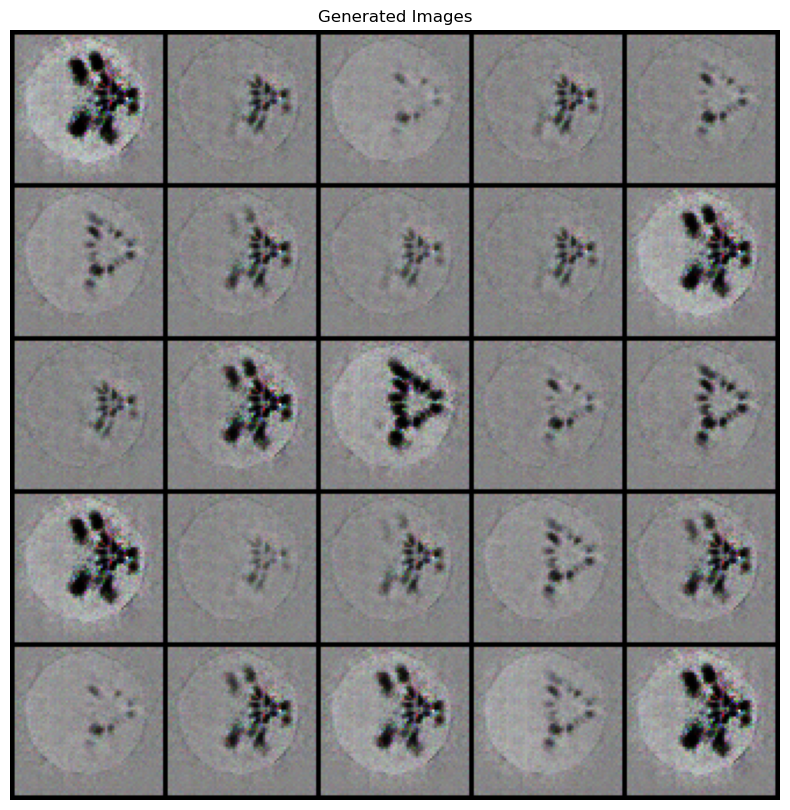

In [25]:
# Function to visualize fake images generated by the generator
def visualize_fake_images(generator, noise_dim, device, num_images=25):
    generator.eval()  # Set generator to evaluation mode
    # Generate random noise vectors
    noise = torch.randn(num_images, noise_dim, 1, 1).to(device)
    
    with torch.no_grad():  # Disable gradient calculation for generating images
        fake_images = generator(noise).detach().cpu()  # Generate fake images
    
    # Create a grid of images for visualization
    grid = vutils.make_grid(fake_images, nrow=5, normalize=True)
    
    # Display the images using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).numpy())  # Convert from CxHxW to HxWxC for displaying
    plt.title("Generated Images")
    plt.axis('off')  # Hide the axes
    plt.show()

# Call the function to visualize generated images from the trained generator
noise_dim = 100  # Assuming your generator uses a noise vector of dimension 100
visualize_fake_images(generator, noise_dim, device)